# Result Analysis
We use the pickled predictions to run our own analysis and create visualizations.

In [6]:
import pickle
import pandas as pd
from mmaction.evaluation.metrics.acc_metric import ConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay
from pathlib import Path
import matplotlib.pyplot as plt

In [27]:
PREDICTIONS_FILE = "notebooks/predictions.pkl"

with open(PREDICTIONS_FILE, "rb") as f:
    predictions = pickle.load(f)

predictions[:3]

gt_labels = [p["gt_label"] for p in predictions]
pred_labels = [p["pred_label"] for p in predictions]
pred_scores = [p["pred_score"] for p in predictions]
pred_labels[:3], pred_scores[:3]

([tensor([2]), tensor([2]), tensor([2])],
 [tensor([0.0289, 0.0320, 0.9390]),
  tensor([0.0346, 0.0424, 0.9230]),
  tensor([0.0303, 0.0563, 0.9135])])

## Confusion Matrix

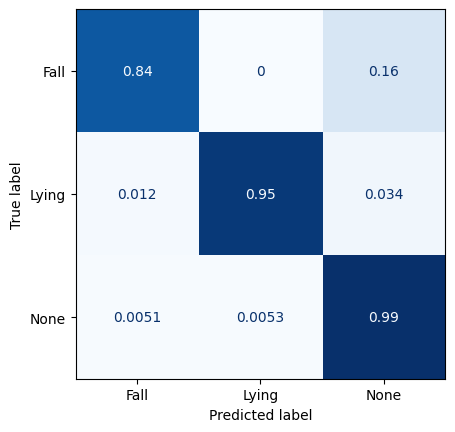

In [31]:
cf = ConfusionMatrixDisplay.from_predictions(
    gt_labels,
    pred_labels,
    normalize="true",
    display_labels=["Fall", "Lying", "None"],
    labels=[0, 1, 2],
    cmap="Blues",
    colorbar=False,
)

# Metrics

In [29]:
from sklearn.metrics import classification_report

print(
    classification_report(
        gt_labels,
        pred_labels,
        target_names=["Fall", "Lying", "Other"],
        output_dict=False,
    )
)

              precision    recall  f1-score   support

        Fall       0.64      0.84      0.73        74
       Lying       0.98      0.95      0.96       983
        None       0.99      0.99      0.99      4544

    accuracy                           0.98      5601
   macro avg       0.87      0.93      0.89      5601
weighted avg       0.98      0.98      0.98      5601



# Loss curves

In [22]:
loss_folder = Path("notebooks/result_data/class_0_f1/")
loss_files = sorted(loss_folder.glob("*.csv"))
loss_dfs = []
for loss_file in loss_files:
    loss_df = pd.read_csv(loss_file)
    loss_df["exp_name"] = loss_file.stem
    loss_dfs.append(loss_df)

losses = pd.concat(loss_dfs)

losses.head()

,Wall time,Step,Value,exp_name
0,1.701888e+09,1,0.095238,vit-b_frame-int-8_gaussian-sampling-5s-clips-3...
1,1.701889e+09,2,0.410256,vit-b_frame-int-8_gaussian-sampling-5s-clips-3...
2,1.701890e+09,3,0.527273,vit-b_frame-int-8_gaussian-sampling-5s-clips-3...
3,1.701891e+09,4,0.500000,vit-b_frame-int-8_gaussian-sampling-5s-clips-3...
4,1.701892e+09,5,0.529915,vit-b_frame-int-8_gaussian-sampling-5s-clips-3...


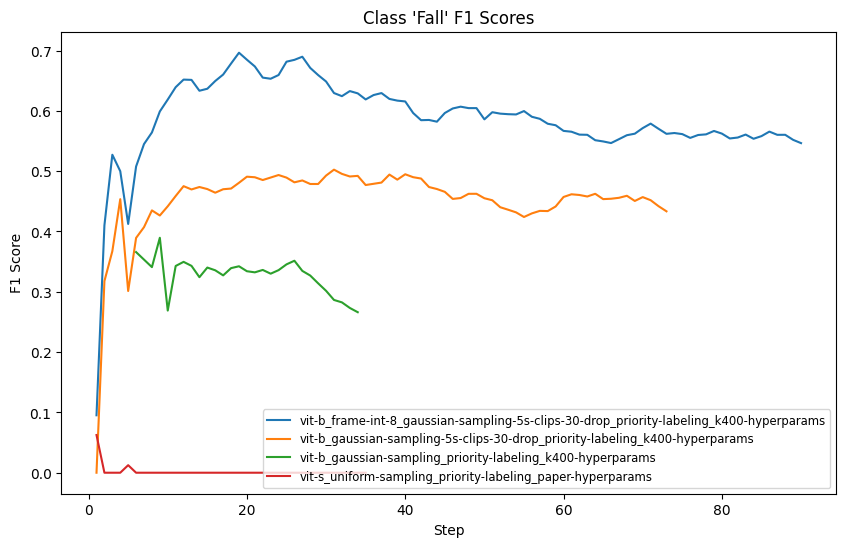

In [26]:
# Plot all experiments over steps

fig = plt.figure(figsize=(10, 6))

grouped_losses = losses.groupby("exp_name")

for name, group in grouped_losses:
    smoothed_values = group["Value"].rolling(window=5).mean()
    smoothed_values = smoothed_values.fillna(group["Value"])  # Apply smoothing with window size 10
    plt.plot(group["Step"], smoothed_values, label=name)

plt.xlabel("Step")
plt.ylabel("F1 Score")
plt.title("Class 'Fall' F1 Scores")
plt.legend(loc="lower right", fontsize="small")
plt.show()

# Merging results to video level